## Predicting

**Importing librairies**


In [48]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt


from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
import geopandas as gpd


https://medium.com/digital-catapult/dealing-with-imbalanced-data-8b21e6deb6cd

**Importing data**

In [49]:
filename_1 = "..\data\_tarefelt1.csv"
filename_2 = "..\data\_tarefelt2.csv"
filename_3 = "..\data\_tarefelt3.csv"

In [50]:
data_1 = pd.read_csv(filename_1)
data_2 = pd.read_csv(filename_2)
data_3 = pd.read_csv(filename_3)

X =  pd.concat([data_1, data_2, data_3])


**Removing the water**

In [70]:
X = X.drop(X[X['label'] == 0].sample(frac=.95).index)

In [90]:
X.columns

Index(['Unnamed: 0', 'band_0', 'band_1', 'band_2', 'band_3', 'band_4',
       'band_5', 'band_6', 'band_7', 'band_8', 'band_9', 'band_10', 'band_11',
       'band_12', 'band_13', 'band_14', 'band_15', 'band_16', 'band_17',
       'band_18', 'band_19', 'band_20', 'band_21', 'band_22', 'band_23',
       'band_24', 'band_25', 'band_26', 'band_27', 'band_28', 'band_29',
       'band_30', 'band_31', 'band_32', 'band_33', 'band_34', 'band_35',
       'band_36', 'band_37', 'band_38', 'band_39', 'band_40', 'band_41',
       'band_42', 'band_43', 'band_44', 'band_45', 'band_46', 'band_47',
       'band_48', 'band_49', 'band_50', 'band_51', 'band_52', 'band_53',
       'band_54', 'band_55', 'band_56', 'band_57', 'band_58', 'band_59',
       'band_60', 'band_61', 'band_62', 'band_63', 'band_64', 'band_65', 'lat',
       'lon', 'geometry', 'label'],
      dtype='object')

In [92]:
X.drop(columns = "Unnamed: 0", inplace = True)

**Splitting data**

Creating balanced datasets using stratified shuffle split

In [93]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

for i, (train_index, test_index) in enumerate(sss.split(X, X.label)):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]


**Feature extracting**

In [94]:
y_train = X_train.label
X_train.drop(columns = ['lat','lon', 'geometry', 'label'], inplace = True)

In [95]:
lat = X_test.lat
lon = X_test.lon
y_test = X_test.label
X_test.drop(columns = ['lat','lon', 'geometry', 'label'], inplace = True)

In [96]:
''' 
oversample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = oversample.fit_resample(X_train, y_train)
'''


" \noversample = RandomUnderSampler(sampling_strategy='majority')\nX_train, y_train = oversample.fit_resample(X_train, y_train)\n"

**Standarscaling**


In [97]:
scaler = StandardScaler()
scaler.fit(X_train) 
scaled_X_train = scaler.transform(X_train)
X_train = pd.DataFrame(scaled_X_train, index= X_train.index, columns=X_train.columns)
scaled_X_test = scaler.transform(X_test)
X_test  = pd.DataFrame(scaled_X_test, index= X_test.index, columns=X_test.columns)

**Training the model**  


In [98]:
def batch(iterable_X, iterable_y, n=1):
    '''
    n: batchsize
    
    '''
    l = len(iterable_X)
    for ndx in range(0, l, n):
        yield iterable_X[ndx:min(ndx + n, l)], iterable_y[ndx:min(ndx + n, l)]


In [99]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = SGDClassifier(loss = "log_loss",  
                    verbose = 50, 
                    warm_start = True, 
                    penalty = "elasticnet", 
                    class_weight= dict(zip(np.unique(y_train), class_weights)))

classes = np.unique(y_train)
accuracy =[]


ROUNDS = 3
count = 0 
batchsize = 1000

#Velger testsize så liten som mulig. Fordi den brukes ikke til noe.
sss = StratifiedShuffleSplit(n_splits=ROUNDS, test_size=0.0001, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X_train, y_train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    X_sgd = X_train.iloc[train_index]
    y_sgd = y_train.iloc[train_index]
    
    batcherator= batch(X_sgd, y_sgd, batchsize)

    for index, (x_batch, y_batch) in enumerate(batcherator):
        print(count)
        count+= 1
        clf.partial_fit(x_batch, y_batch, classes)
        y_predicted = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_predicted))

ValueError: The test_size = 1 should be greater or equal to the number of classes = 2

**Plotting accuracy**

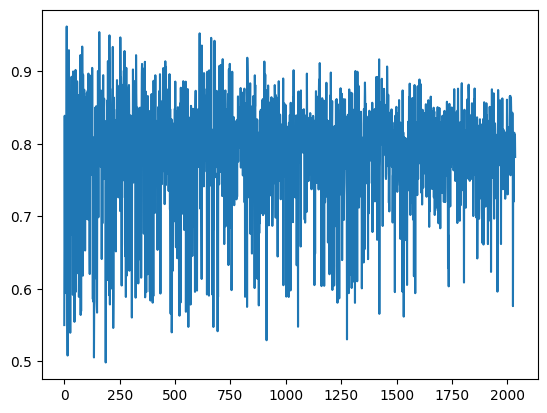

In [63]:
plt.plot(accuracy)

**Evaluating Model**


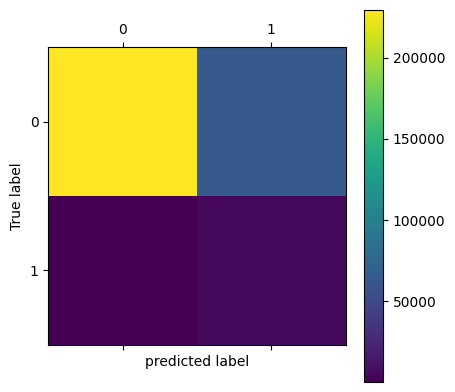

In [64]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted)
# Plot matrix
plt.matshow(conf_mat)
plt.colorbar()
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

**Checking over the test set**

In [65]:
y_predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"The accuracy of the model was {np.round(accuracy,2)}")

The accuracy of the model was 0.78


**Plotting the predicted seaweed and comparing with naturdirektoratet**

In [66]:
X_final = X_test.copy()
X_final["label"] = y_test
X_final["y_predicted"] = y_predicted
X_final = gpd.GeoDataFrame(X_final, geometry=gpd.points_from_xy(lon, lat))

df_no_seaweed = X_final[X_final["y_predicted"] == 0].copy()
df_seaweed = X_final[X_final["y_predicted"] == 1].copy()
df_true_seaweed = X_final[X_final["label"] == True].copy()

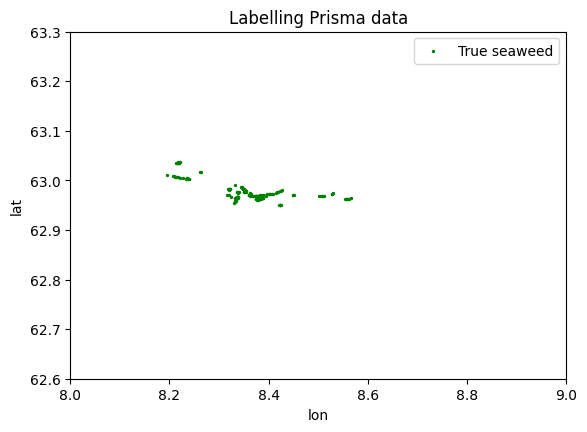

In [69]:
fig, ax = plt.subplots()
df_no_seaweed.plot(ax = ax, color = "blue", label = "no seaweed")
df_true_seaweed.plot(ax = ax, color = "green", label = "True seaweed", markersize = 2)
df_seaweed.plot(ax = ax, color = "red", label = "Seaweed", markersize = 1)

ax.set_title("Labelling Prisma data")
ax.set_xlabel("lon")
ax.set_ylabel("lat")
ax.set_ylim(62.6, 63.3)
ax.set_xlim(8,9)
ax.legend()